# Obstklassifikation mit Custom CNN-Modell

Dieses Notebook implementiert ein Custom Convolutional Neural Network (CNN) zur Klassifikation von Obstbildern.

## Übersicht:
1. Import der benötigten Bibliotheken
2. Konfiguration der Obstklassen (erweiterbar)
3. Laden und Vorbereiten der Daten
4. Aufbau des CNN-Modells
5. Training des Modells
6. Evaluation und Visualisierung
7. Vorhersagen auf eigenen Bildern

**Datensatz:** Fruits-360 (100x100 Pixel Bilder)

## 1. Import der benötigten Bibliotheken

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
import glob

# TensorFlow und Keras - Alle Imports konsistent über tensorflow.keras
import tensorflow as tf

# Verwende tf.keras für alle Keras-Importe (kompatibel mit TensorFlow 2.x)
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Scikit-learn für Evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Warnungen unterdrücken
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU verfügbar: {tf.config.list_physical_devices('GPU')}")

TensorFlow Version: 2.20.0
GPU verfügbar: []


## 2. Konfiguration der Obstklassen

Hier werden die zu verwendenden Obstklassen definiert. Diese Liste ist **vollständig konfigurierbar** - Sie können beliebig Klassen hinzufügen oder entfernen.

In [2]:
# ============================================
# KONFIGURATION - Hier können Sie Klassen anpassen
# ============================================

# Liste der gewünschten Obstklassen
FRUIT_CLASSES = [
    'Apple',
    'Banana', 
    'Cherry',
    'Kiwi',
    'Lemon',
    'Orange',
    'Peach',
    'Strawberry',
    'Tomato'
]

# Pfade zu den Datenverzeichnissen
DATA_ROOT = r'C:\source\mkufka\ML\Bilder'
TRAIN_DIR = os.path.join(DATA_ROOT, 'Training')
TEST_DIR = os.path.join(DATA_ROOT, 'Test')

# Pfad zum Ausgabeverzeichnis (im Workspace)
WORKSPACE_ROOT = r'C:\source\mkufka\ML'
MODEL_OUTPUT_DIR = os.path.join(WORKSPACE_ROOT, 'model_output')
os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)

# Pfad für Vorhersagen auf eigenen Bildern
CUSTOM_IMAGES_DIR = os.path.join(WORKSPACE_ROOT, 'Obst')

# Modellparameter
IMG_SIZE = (100, 100)  # Größe der Trainingsbilder
BATCH_SIZE = 32
EPOCHS = 25
NUM_CLASSES = len(FRUIT_CLASSES)

print(f"Anzahl der Klassen: {NUM_CLASSES}")
print(f"Klassen: {FRUIT_CLASSES}")
print(f"\nDatenverzeichnisse:")
print(f"  Training: {TRAIN_DIR}")
print(f"  Test: {TEST_DIR}")
print(f"  Eigene Bilder: {CUSTOM_IMAGES_DIR}")
print(f"  Modell-Ausgabe: {MODEL_OUTPUT_DIR}")

Anzahl der Klassen: 9
Klassen: ['Apple', 'Banana', 'Cherry', 'Kiwi', 'Lemon', 'Orange', 'Peach', 'Strawberry', 'Tomato']

Datenverzeichnisse:
  Training: C:\source\mkufka\ML\Bilder\Training
  Test: C:\source\mkufka\ML\Bilder\Test
  Eigene Bilder: C:\source\mkufka\ML\Obst
  Modell-Ausgabe: C:\source\mkufka\ML\model_output


## 3. Identifizierung der relevanten Ordner

Wir suchen nur nach Ordnern, die mit den definierten Klassennamen **beginnen** (z.B. "Apple 5", "Apple 6" für die Klasse "Apple").

In [3]:
def find_matching_folders(base_dir, fruit_classes):
    """
    Findet alle Ordner, die mit einem der Klassennamen beginnen.
    
    Args:
        base_dir: Basisverzeichnis (Training oder Test)
        fruit_classes: Liste der gewünschten Klassen
        
    Returns:
        Dictionary mit Klassenname -> Liste der Ordnerpfade
    """
    matching_folders = {}
    
    if not os.path.exists(base_dir):
        print(f"WARNUNG: Verzeichnis nicht gefunden: {base_dir}")
        return matching_folders
    
    all_folders = [f for f in os.listdir(base_dir) 
                   if os.path.isdir(os.path.join(base_dir, f))]
    
    for fruit_class in fruit_classes:
        # Finde alle Ordner, die mit dem Klassennamen beginnen
        class_folders = [f for f in all_folders if f.startswith(fruit_class)]
        matching_folders[fruit_class] = class_folders
        
    return matching_folders

# Finde passende Ordner für Training und Test
train_folders = find_matching_folders(TRAIN_DIR, FRUIT_CLASSES)
test_folders = find_matching_folders(TEST_DIR, FRUIT_CLASSES)

print("=" * 60)
print("GEFUNDENE ORDNER FÜR JEDE KLASSE")
print("=" * 60)

for fruit_class in FRUIT_CLASSES:
    train_count = len(train_folders.get(fruit_class, []))
    test_count = len(test_folders.get(fruit_class, []))
    print(f"\n{fruit_class}:")
    print(f"  Training: {train_count} Ordner")
    print(f"  Test: {test_count} Ordner")
    
    # Zeige Beispiele
    if train_count > 0:
        print(f"  Beispiele (Training): {', '.join(train_folders[fruit_class][:3])}")
    if test_count > 0:
        print(f"  Beispiele (Test): {', '.join(test_folders[fruit_class][:3])}")

GEFUNDENE ORDNER FÜR JEDE KLASSE

Apple:
  Training: 1 Ordner
  Test: 1 Ordner
  Beispiele (Training): Apple
  Beispiele (Test): Apple

Banana:
  Training: 1 Ordner
  Test: 1 Ordner
  Beispiele (Training): Banana
  Beispiele (Test): Banana

Cherry:
  Training: 1 Ordner
  Test: 1 Ordner
  Beispiele (Training): Cherry
  Beispiele (Test): Cherry

Kiwi:
  Training: 1 Ordner
  Test: 1 Ordner
  Beispiele (Training): Kiwi
  Beispiele (Test): Kiwi

Lemon:
  Training: 1 Ordner
  Test: 1 Ordner
  Beispiele (Training): Lemon
  Beispiele (Test): Lemon

Orange:
  Training: 1 Ordner
  Test: 1 Ordner
  Beispiele (Training): Orange
  Beispiele (Test): Orange

Peach:
  Training: 1 Ordner
  Test: 1 Ordner
  Beispiele (Training): Peach
  Beispiele (Test): Peach

Strawberry:
  Training: 1 Ordner
  Test: 1 Ordner
  Beispiele (Training): Strawberry
  Beispiele (Test): Strawberry

Tomato:
  Training: 1 Ordner
  Test: 1 Ordner
  Beispiele (Training): Tomato
  Beispiele (Test): Tomato


## 4. Erstellen von symbolischen Links für die Datenstruktur

Da wir nur bestimmte Ordner verwenden möchten und das Original-Verzeichnis nicht ändern dürfen, erstellen wir eine temporäre Ordnerstruktur mit symbolischen Links im Workspace.

In [4]:
import shutil

def create_filtered_dataset_structure(base_dir, output_dir, folder_mapping, fruit_classes):
    """
    Erstellt eine gefilterte Datenstruktur durch Kopieren der Bilder.
    
    Args:
        base_dir: Quellverzeichnis (Training oder Test)
        output_dir: Zielverzeichnis
        folder_mapping: Dictionary mit Klassenname -> Liste der Ordner
        fruit_classes: Liste der Klassen
    """
    # Lösche altes Verzeichnis falls vorhanden
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    
    os.makedirs(output_dir, exist_ok=True)
    
    total_images = 0
    
    for fruit_class in fruit_classes:
        class_output_dir = os.path.join(output_dir, fruit_class)
        os.makedirs(class_output_dir, exist_ok=True)
        
        class_folders = folder_mapping.get(fruit_class, [])
        class_image_count = 0
        
        for folder in class_folders:
            source_folder = os.path.join(base_dir, folder)
            
            # Kopiere alle Bilder aus diesem Ordner
            if os.path.exists(source_folder):
                for img_file in os.listdir(source_folder):
                    if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                        source_file = os.path.join(source_folder, img_file)
                        dest_file = os.path.join(class_output_dir, f"{folder}_{img_file}")
                        shutil.copy2(source_file, dest_file)
                        class_image_count += 1
        
        total_images += class_image_count
        print(f"{fruit_class}: {class_image_count} Bilder kopiert")
    
    print(f"\nGesamt: {total_images} Bilder")
    return total_images

# Erstelle gefilterte Datenstruktur
FILTERED_TRAIN_DIR = os.path.join(WORKSPACE_ROOT, 'filtered_data', 'Training')
FILTERED_TEST_DIR = os.path.join(WORKSPACE_ROOT, 'filtered_data', 'Test')

print("Erstelle gefilterte Trainings-Daten...")
train_count = create_filtered_dataset_structure(TRAIN_DIR, FILTERED_TRAIN_DIR, 
                                                 train_folders, FRUIT_CLASSES)

print("\nErstelle gefilterte Test-Daten...")
test_count = create_filtered_dataset_structure(TEST_DIR, FILTERED_TEST_DIR, 
                                                test_folders, FRUIT_CLASSES)

print(f"\n{'='*60}")
print(f"DATEN ERFOLGREICH VORBEREITET")
print(f"{'='*60}")
print(f"Training: {train_count} Bilder in {FILTERED_TRAIN_DIR}")
print(f"Test: {test_count} Bilder in {FILTERED_TEST_DIR}")

Erstelle gefilterte Trainings-Daten...
Apple: 7571 Bilder kopiert
Banana: 977 Bilder kopiert
Cherry: 3321 Bilder kopiert
Kiwi: 466 Bilder kopiert
Lemon: 492 Bilder kopiert
Orange: 479 Bilder kopiert
Peach: 4311 Bilder kopiert
Strawberry: 492 Bilder kopiert
Tomato: 6129 Bilder kopiert

Gesamt: 24238 Bilder

Erstelle gefilterte Test-Daten...
Apple: 2509 Bilder kopiert
Banana: 327 Bilder kopiert
Cherry: 1100 Bilder kopiert
Kiwi: 156 Bilder kopiert
Lemon: 164 Bilder kopiert
Orange: 160 Bilder kopiert
Peach: 1433 Bilder kopiert
Strawberry: 164 Bilder kopiert
Tomato: 2036 Bilder kopiert

Gesamt: 8049 Bilder

DATEN ERFOLGREICH VORBEREITET
Training: 24238 Bilder in C:\source\mkufka\ML\filtered_data\Training
Test: 8049 Bilder in C:\source\mkufka\ML\filtered_data\Test


## 5. Visualisierung von Beispielbildern

Zeige einige Beispielbilder aus jeder Klasse zur Überprüfung.

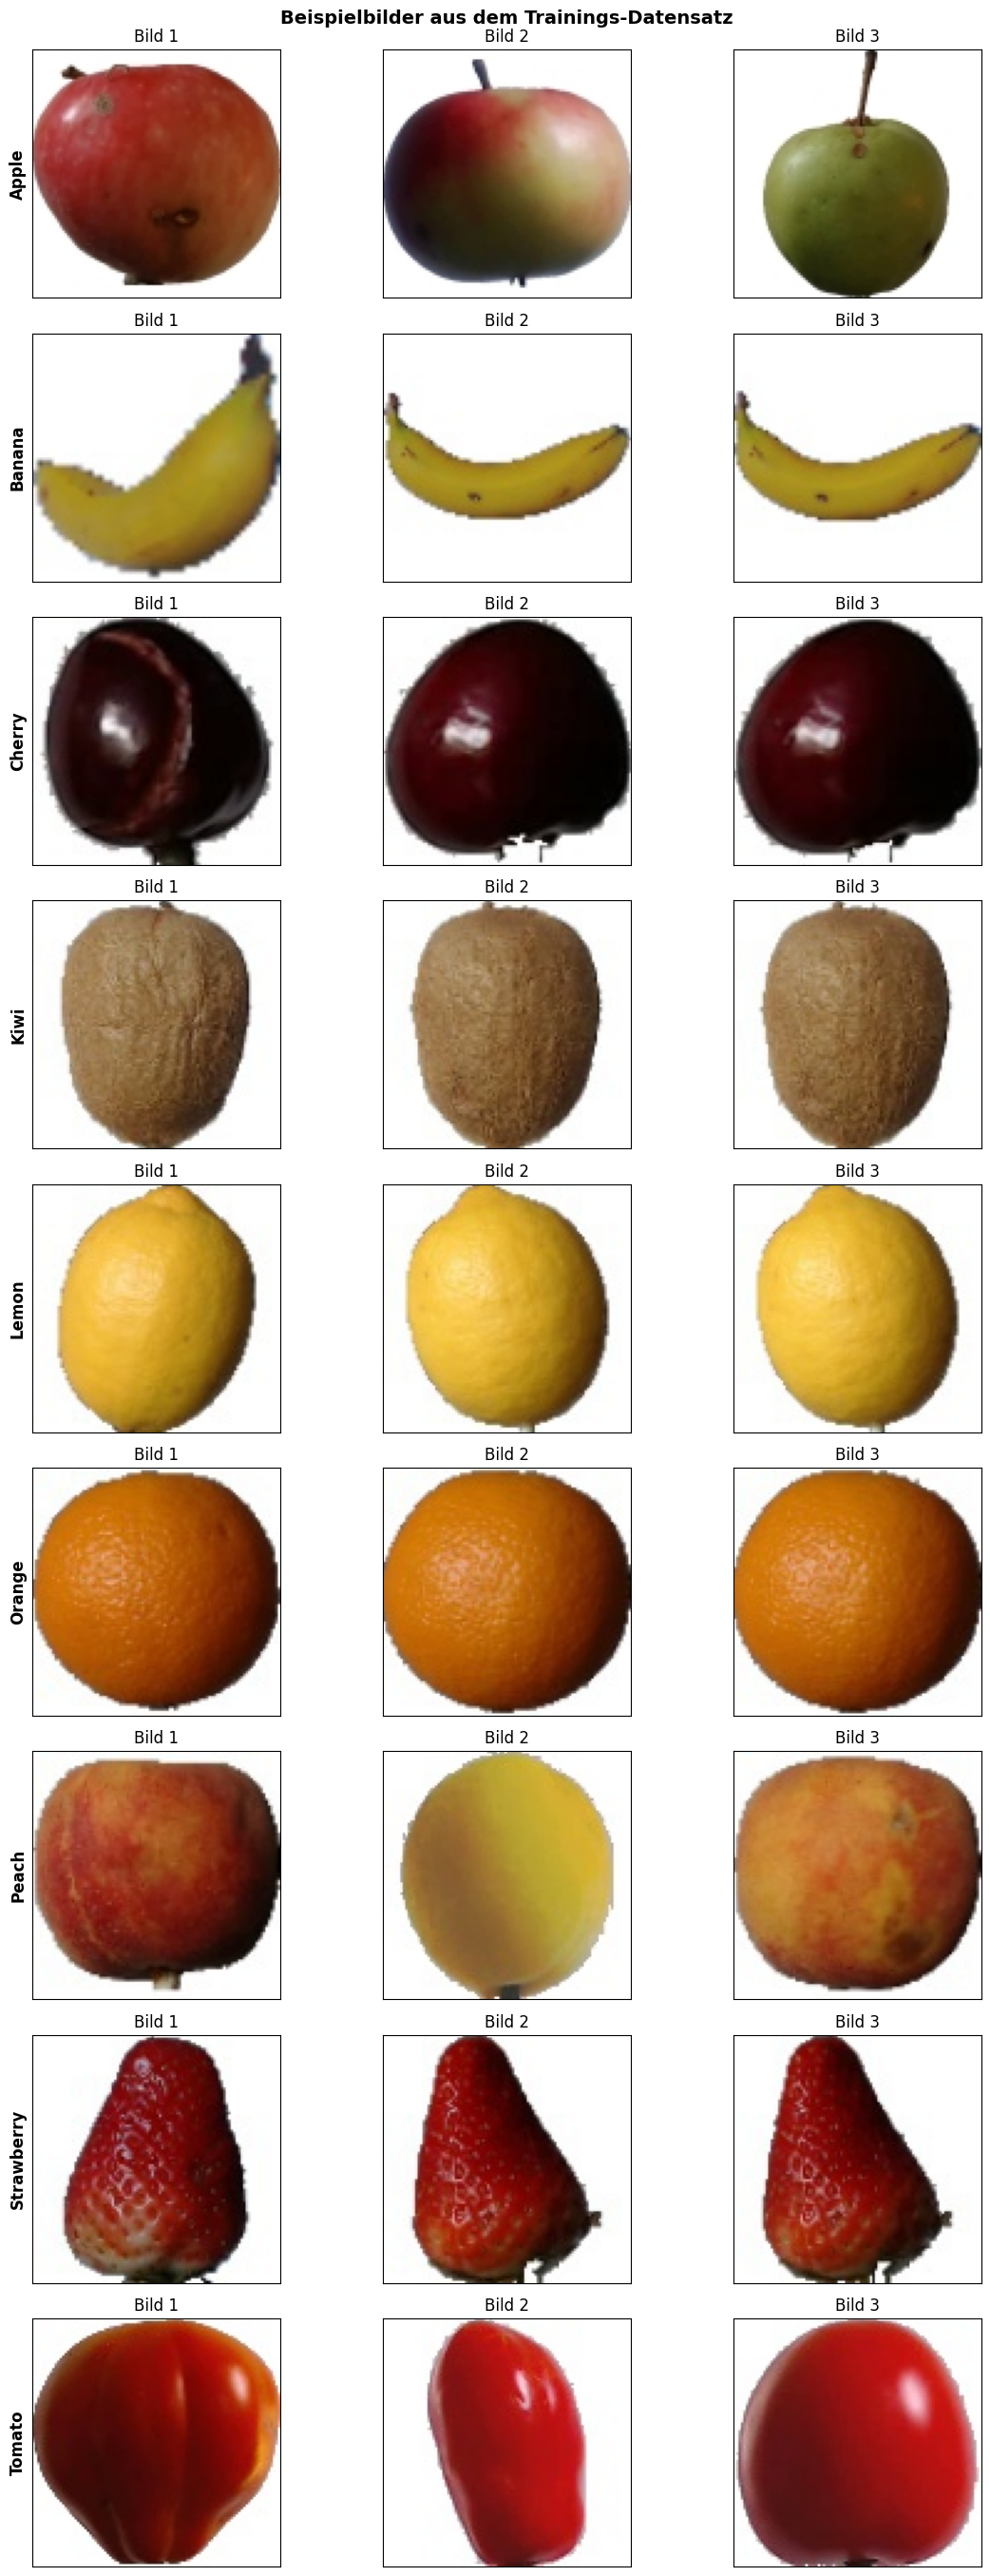

In [5]:
def show_sample_images(data_dir, fruit_classes, samples_per_class=3):
    """Zeigt Beispielbilder für jede Klasse."""
    fig, axes = plt.subplots(len(fruit_classes), samples_per_class, 
                             figsize=(12, 3*len(fruit_classes)))
    
    if len(fruit_classes) == 1:
        axes = axes.reshape(1, -1)
    
    for i, fruit_class in enumerate(fruit_classes):
        class_dir = os.path.join(data_dir, fruit_class)
        
        if os.path.exists(class_dir):
            images = [f for f in os.listdir(class_dir) 
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            
            for j in range(samples_per_class):
                ax = axes[i, j]
                
                if j < len(images):
                    img_path = os.path.join(class_dir, images[j])
                    img = load_img(img_path)
                    ax.imshow(img)
                    
                    if j == 0:
                        ax.set_ylabel(fruit_class, fontsize=12, fontweight='bold')
                else:
                    ax.axis('off')
                
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_title(f"Bild {j+1}")
    
    plt.tight_layout()
    plt.suptitle('Beispielbilder aus dem Trainings-Datensatz', 
                 fontsize=14, fontweight='bold', y=1.002)
    plt.show()

show_sample_images(FILTERED_TRAIN_DIR, FRUIT_CLASSES, samples_per_class=3)

## 6. Daten-Generatoren erstellen

Wir verwenden `ImageDataGenerator` für:
- Normalisierung der Pixelwerte (0-1)
- Data Augmentation für das Training (optional)
- Automatisches Laden der Bilder in Batches

In [6]:
# Data Augmentation für Training (optional - verbessert Generalisierung)
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalisierung
    rotation_range=20,            # Zufällige Rotation
    width_shift_range=0.2,        # Horizontale Verschiebung
    height_shift_range=0.2,       # Vertikale Verschiebung
    horizontal_flip=True,         # Horizontales Spiegeln
    zoom_range=0.2,               # Zoom
    validation_split=0.2          # 20% für Validierung
)

# Nur Normalisierung für Test-Daten
test_datagen = ImageDataGenerator(rescale=1./255)

# Training Generator
train_generator = train_datagen.flow_from_directory(
    FILTERED_TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

# Validierung Generator
validation_generator = train_datagen.flow_from_directory(
    FILTERED_TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

# Test Generator
test_generator = test_datagen.flow_from_directory(
    FILTERED_TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("Data Generators erstellt:")
print(f"  Training: {train_generator.samples} Bilder")
print(f"  Validierung: {validation_generator.samples} Bilder")
print(f"  Test: {test_generator.samples} Bilder")
print(f"\nKlassen-Mapping:")
class_indices = train_generator.class_indices
for class_name, index in sorted(class_indices.items(), key=lambda x: x[1]):
    print(f"  {index}: {class_name}")

Found 19394 images belonging to 9 classes.
Found 4844 images belonging to 9 classes.
Found 8049 images belonging to 9 classes.
Data Generators erstellt:
  Training: 19394 Bilder
  Validierung: 4844 Bilder
  Test: 8049 Bilder

Klassen-Mapping:
  0: Apple
  1: Banana
  2: Cherry
  3: Kiwi
  4: Lemon
  5: Orange
  6: Peach
  7: Strawberry
  8: Tomato


## 7. Custom CNN-Modell aufbauen

Wir erstellen ein Custom Convolutional Neural Network mit mehreren Conv2D-Schichten, MaxPooling und Dropout zur Regularisierung.

In [7]:
def build_cnn_model(input_shape, num_classes):
    """
    Erstellt ein Custom CNN-Modell für Bildklassifikation.
    
    Architektur:
    - 3 Convolutional Blocks (Conv2D + BatchNorm + MaxPool + Dropout)
    - Global Average Pooling
    - Dense Layers mit Dropout
    - Output Layer mit Softmax
    """
    model = models.Sequential([
        # Input Layer
        layers.Input(shape=input_shape),
        
        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 4 (Optional - tiefere Features)
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Global Average Pooling (besser als Flatten)
        layers.GlobalAveragePooling2D(),
        
        # Dense Layers
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        # Output Layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Modell erstellen
input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)
model = build_cnn_model(input_shape, NUM_CLASSES)

# Modell-Zusammenfassung
print("=" * 60)
print("MODELL-ARCHITEKTUR")
print("=" * 60)
model.summary()

# Anzahl der trainierbaren Parameter
trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
print(f"\nTrainierbare Parameter: {trainable_params:,}")

MODELL-ARCHITEKTUR


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,444,393 (5.51 MB)

 Trainable params: 1,440,937 (5.50 MB)

 Non-trainable params: 3,456 (13.50 KB)


Trainierbare Parameter: 1,440,937


## 8. Modell kompilieren

Wir verwenden:
- **Optimizer:** Adam (adaptiver Lernrate)
- **Loss:** Categorical Crossentropy (für Multi-Class Klassifikation)
- **Metrics:** Accuracy

In [8]:
# Optimizer mit initialer Lernrate
optimizer = keras.optimizers.Adam(learning_rate=0.001)

# Modell kompilieren
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Modell erfolgreich kompiliert!")
print(f"Optimizer: Adam")
print(f"Loss Function: Categorical Crossentropy")
print(f"Metrics: Accuracy")

NameError: name 'keras' is not defined

## 9. Callbacks definieren

Wir verwenden:
- **ModelCheckpoint:** Speichert das beste Modell
- **EarlyStopping:** Stoppt Training bei Stagnation
- **ReduceLROnPlateau:** Reduziert Lernrate bei Plateau

In [12]:
# Pfad für das beste Modell
model_path = os.path.join(MODEL_OUTPUT_DIR, 'best_fruit_classifier_cnn.keras')

# Callbacks
callbacks = [
    # Speichere das beste Modell basierend auf Validierungs-Accuracy
    ModelCheckpoint(
        model_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    
    # Early Stopping - stoppt wenn keine Verbesserung mehr
    EarlyStopping(
        monitor='val_accuracy',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Reduziere Lernrate bei Plateau
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

print("Callbacks konfiguriert:")
print(f"  - ModelCheckpoint: {model_path}")
print(f"  - EarlyStopping: Patience=7")
print(f"  - ReduceLROnPlateau: Factor=0.5, Patience=3")

Callbacks konfiguriert:
  - ModelCheckpoint: C:\Projekte\ML\model_output\best_fruit_classifier_cnn.keras
  - EarlyStopping: Patience=7
  - ReduceLROnPlateau: Factor=0.5, Patience=3


## 10. Training des Modells

Dies kann einige Minuten dauern, abhängig von Ihrer Hardware (GPU beschleunigt das Training erheblich).

In [13]:
print("=" * 60)
print("STARTE TRAINING")
print("=" * 60)
print(f"Epochen: {EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Training Samples: {train_generator.samples}")
print(f"Validation Samples: {validation_generator.samples}")
print("=" * 60)

# Training starten
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "=" * 60)
print("TRAINING ABGESCHLOSSEN!")
print("=" * 60)

STARTE TRAINING
Epochen: 25
Batch Size: 32
Training Samples: 36335
Validation Samples: 9079
Epoch 1/25
Epoch 1/25
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.6754 - loss: 1.0769
Epoch 1: val_accuracy improved from None to 0.69854, saving model to C:\Projekte\ML\model_output\best_fruit_classifier_cnn.keras

Epoch 1: val_accuracy improved from None to 0.69854, saving model to C:\Projekte\ML\model_output\best_fruit_classifier_cnn.keras
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 516s 451ms/step - accuracy: 0.7821 - loss: 0.6851 - val_accuracy: 0.6985 - val_loss: 1.7425 - learning_rate: 0.0010
Epoch 2/25
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 516s 451ms/step - accuracy: 0.7821 - loss: 0.6851 - val_accuracy: 0.6985 - val_loss: 1.7425 - learning_rate: 0.0010
Epoch 2/25
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.9124 - loss: 0.2658
Epoch 2: val_accuracy did not improve from 0.69854
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 318s 280ms/step - accuracy: 0.9222 - loss: 0.2348 - val_accuracy: 0.682

## 11. Visualisierung des Trainings-Verlaufs

Zeige die Entwicklung von Accuracy und Loss über die Epochen.

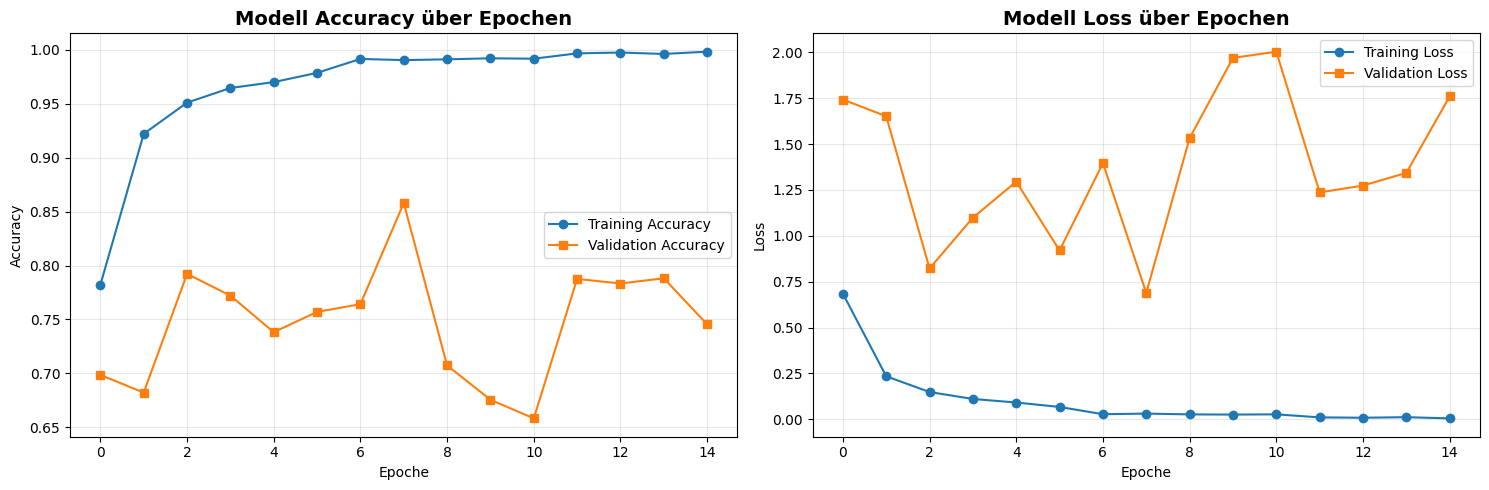


FINALE TRAINING-METRIKEN
Training Accuracy:   0.9984
Validation Accuracy: 0.7455
Training Loss:       0.0054
Validation Loss:     1.7597


In [14]:
def plot_training_history(history):
    """Visualisiert den Trainings-Verlauf."""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy Plot
    axes[0].plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
    axes[0].set_title('Modell Accuracy über Epochen', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoche')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Loss Plot
    axes[1].plot(history.history['loss'], label='Training Loss', marker='o')
    axes[1].plot(history.history['val_loss'], label='Validation Loss', marker='s')
    axes[1].set_title('Modell Loss über Epochen', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoche')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Ausgabe der finalen Metriken
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    
    print("\n" + "=" * 60)
    print("FINALE TRAINING-METRIKEN")
    print("=" * 60)
    print(f"Training Accuracy:   {final_train_acc:.4f}")
    print(f"Validation Accuracy: {final_val_acc:.4f}")
    print(f"Training Loss:       {final_train_loss:.4f}")
    print(f"Validation Loss:     {final_val_loss:.4f}")
    print("=" * 60)

plot_training_history(history)

## 12. Evaluation auf Test-Daten

Bewerte das Modell auf den ungesehenen Test-Daten.

In [15]:
print("=" * 60)
print("EVALUATION AUF TEST-DATEN")
print("=" * 60)

# Lade das beste gespeicherte Modell
best_model = keras.models.load_model(model_path)
print(f"Bestes Modell geladen von: {model_path}")

# Evaluate auf Test-Daten
test_loss, test_accuracy = best_model.evaluate(test_generator, verbose=1)

print("\n" + "=" * 60)
print("TEST-ERGEBNISSE")
print("=" * 60)
print(f"Test Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print("=" * 60)

EVALUATION AUF TEST-DATEN
Bestes Modell geladen von: C:\Projekte\ML\model_output\best_fruit_classifier_cnn.keras
Bestes Modell geladen von: C:\Projekte\ML\model_output\best_fruit_classifier_cnn.keras
473/473 ━━━━━━━━━━━━━━━━━━━━ 90s 190ms/step - accuracy: 0.9699 - loss: 0.1588
473/473 ━━━━━━━━━━━━━━━━━━━━ 90s 190ms/step - accuracy: 0.9699 - loss: 0.1588

TEST-ERGEBNISSE
Test Loss:     0.1588
Test Accuracy: 0.9699 (96.99%)

TEST-ERGEBNISSE
Test Loss:     0.1588
Test Accuracy: 0.9699 (96.99%)


## 13. Detaillierte Metriken und Confusion Matrix

Berechne Precision, Recall, F1-Score und visualisiere die Confusion Matrix.

Erstelle Vorhersagen...
473/473 ━━━━━━━━━━━━━━━━━━━━ 27s 57ms/step
473/473 ━━━━━━━━━━━━━━━━━━━━ 27s 57ms/step

CLASSIFICATION REPORT
              precision    recall  f1-score   support

       Apple       0.93      1.00      0.96      5348
      Banana       1.00      1.00      1.00       645
      Cherry       1.00      0.95      0.97      3048
        Kiwi       1.00      1.00      1.00       156
       Lemon       1.00      1.00      1.00       330
      Orange       0.84      1.00      0.91       160
       Peach       0.99      0.93      0.96      1597
  Strawberry       1.00      0.99      1.00       410
      Tomato       0.99      0.96      0.98      3413

    accuracy                           0.97     15107
   macro avg       0.97      0.98      0.98     15107
weighted avg       0.97      0.97      0.97     15107


CONFUSION MATRIX

CLASSIFICATION REPORT
              precision    recall  f1-score   support

       Apple       0.93      1.00      0.96      5348
      Banana

<Figure size 1200x1000 with 0 Axes>

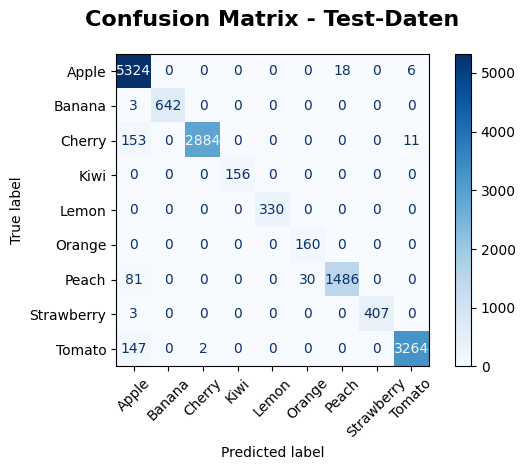


Pro-Klasse Accuracy:
----------------------------------------
Apple       : 0.9955 (99.55%) - 5324/5348
Banana      : 0.9953 (99.53%) - 642/645
Cherry      : 0.9462 (94.62%) - 2884/3048
Kiwi        : 1.0000 (100.00%) - 156/156
Lemon       : 1.0000 (100.00%) - 330/330
Orange      : 1.0000 (100.00%) - 160/160
Peach       : 0.9305 (93.05%) - 1486/1597
Strawberry  : 0.9927 (99.27%) - 407/410
Tomato      : 0.9563 (95.63%) - 3264/3413


In [16]:
# Vorhersagen auf Test-Daten
print("Erstelle Vorhersagen...")
y_pred_probs = best_model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Class Labels
class_labels = list(test_generator.class_indices.keys())

# Classification Report
print("\n" + "=" * 60)
print("CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("\n" + "=" * 60)
print("CONFUSION MATRIX")
print("=" * 60)

# Visualisierung der Confusion Matrix
plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45, values_format='d')
plt.title('Confusion Matrix - Test-Daten', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Pro-Klasse Accuracy
print("\nPro-Klasse Accuracy:")
print("-" * 40)
for i, label in enumerate(class_labels):
    class_correct = cm[i, i]
    class_total = cm[i, :].sum()
    class_acc = class_correct / class_total if class_total > 0 else 0
    print(f"{label:12s}: {class_acc:.4f} ({class_acc*100:.2f}%) - {class_correct}/{class_total}")

## 14. Beispiel-Vorhersagen visualisieren

Zeige einige Test-Bilder mit ihren Vorhersagen.

In [10]:
def show_predictions(generator, predictions, true_labels, class_labels, num_samples=12):
    """Zeigt Vorhersagen für zufällige Test-Bilder."""
    # Zufällige Auswahl
    indices = np.random.choice(len(true_labels), num_samples, replace=False)
    
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.ravel()
    
    for i, idx in enumerate(indices):
        # Lade Bild
        img_path = generator.filepaths[idx]
        img = load_img(img_path, target_size=IMG_SIZE)
        
        # Wahre und vorhergesagte Klasse
        true_class = class_labels[true_labels[idx]]
        pred_class = class_labels[predictions[idx]]
        confidence = y_pred_probs[idx][predictions[idx]] * 100
        
        # Farbe: Grün für korrekt, Rot für falsch
        color = 'green' if true_class == pred_class else 'red'
        
        # Visualisierung
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(
            f"Wahr: {true_class}\nVorhersage: {pred_class}\nKonfidenz: {confidence:.1f}%",
            fontsize=10,
            color=color,
            fontweight='bold'
        )
    
    plt.tight_layout()
    plt.suptitle('Beispiel-Vorhersagen (Grün = Korrekt, Rot = Falsch)', 
                 fontsize=14, fontweight='bold', y=1.002)
    plt.show()

show_predictions(test_generator, y_pred, y_true, class_labels, num_samples=12)

NameError: name 'y_pred' is not defined

## 15. Modell und Mapping speichern

Speichere das finale Modell und das Label-Mapping für spätere Verwendung.

In [18]:
# Speichere Label-Mapping
label_map_path = os.path.join(MODEL_OUTPUT_DIR, 'label_mapping_cnn.json')

# Erstelle Mapping: Index -> Klassenname
index_to_class = {v: k for k, v in train_generator.class_indices.items()}

with open(label_map_path, 'w') as f:
    json.dump(index_to_class, f, indent=4)

print("=" * 60)
print("MODELL UND MAPPING GESPEICHERT")
print("=" * 60)
print(f"Modell:         {model_path}")
print(f"Label-Mapping:  {label_map_path}")
print("\nLabel-Mapping:")
for idx, label in sorted(index_to_class.items()):
    print(f"  {idx}: {label}")
print("=" * 60)

MODELL UND MAPPING GESPEICHERT
Modell:         C:\Projekte\ML\model_output\best_fruit_classifier_cnn.keras
Label-Mapping:  C:\Projekte\ML\model_output\label_mapping_cnn.json

Label-Mapping:
  0: Apple
  1: Banana
  2: Cherry
  3: Kiwi
  4: Lemon
  5: Orange
  6: Peach
  7: Strawberry
  8: Tomato


## 16. Vorhersagen auf eigenen Bildern aus dem "Obst" Ordner

Jetzt können wir Vorhersagen auf beliebigen Bildern (jedes Format, jede Größe) aus dem "Obst"-Ordner machen!

In [ ]:
def predict_custom_image(model, img_path, label_map, target_size=(100, 100)):
    """
    Macht eine Vorhersage für ein einzelnes Bild mit korrektem Seitenverhältnis.
    
    Args:
        model: Trainiertes Keras-Modell
        img_path: Pfad zum Bild
        label_map: Dictionary mit Index -> Klassenname
        target_size: Zielgröße für das Bild
        
    Returns:
        predicted_class, confidence, all_probabilities
    """
    from PIL import Image
    
    # Lade Original-Bild
    img = Image.open(img_path)
    
    # Konvertiere zu RGB falls nötig (z.B. bei PNG mit Alpha-Kanal)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    
    # Berechne Seitenverhältnis und erstelle quadratisches Bild mit Padding
    width, height = img.size
    max_dim = max(width, height)
    
    # Erstelle schwarzes quadratisches Bild
    square_img = Image.new('RGB', (max_dim, max_dim), (0, 0, 0))
    
    # Platziere Original-Bild zentriert
    offset_x = (max_dim - width) // 2
    offset_y = (max_dim - height) // 2
    square_img.paste(img, (offset_x, offset_y))
    
    # Resize auf Zielgröße (jetzt ohne Verzerrung)
    square_img = square_img.resize(target_size, Image.LANCZOS)
    
    # Konvertiere zu Array und preprocessing
    img_array = img_to_array(square_img)
    img_array = img_array / 255.0  # Normalisierung
    img_array = np.expand_dims(img_array, axis=0)  # Batch-Dimension hinzufügen
    
    # Vorhersage
    predictions = model.predict(img_array, verbose=0)
    predicted_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_idx]
    predicted_class = label_map[str(predicted_idx)]
    
    return predicted_class, confidence, predictions[0]


def predict_on_custom_images(model, images_dir, label_map, target_size=(100, 100)):
    """
    Macht Vorhersagen auf allen Bildern in einem Verzeichnis.
    """
    # Finde alle Bilder
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.gif']
    image_files = []
    
    for ext in image_extensions:
        image_files.extend(glob.glob(os.path.join(images_dir, ext)))
        image_files.extend(glob.glob(os.path.join(images_dir, ext.upper())))
    
    if len(image_files) == 0:
        print(f"WARNUNG: Keine Bilder gefunden in {images_dir}")
        print(f"Unterstützte Formate: {', '.join(image_extensions)}")
        return
    
    print(f"Gefunden: {len(image_files)} Bilder")
    print("=" * 60)
    
    # Erstelle Visualisierung
    num_images = len(image_files)
    cols = 4
    rows = (num_images + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
    
    if num_images == 1:
        axes = np.array([axes])
    axes = axes.ravel()
    
    # Vorhersagen für jedes Bild
    for i, img_path in enumerate(image_files):
        # Vorhersage
        predicted_class, confidence, all_probs = predict_custom_image(
            model, img_path, label_map, target_size
        )
        
        # Lade Original-Bild (für Anzeige)
        img = load_img(img_path)
        
        # Visualisierung
        axes[i].imshow(img)
        axes[i].axis('off')
        
        # Titel mit Vorhersage und Konfidenz
        filename = os.path.basename(img_path)
        axes[i].set_title(
            f"{filename}\n\n{predicted_class}\nKonfidenz: {confidence*100:.1f}%",
            fontsize=10,
            fontweight='bold',
            color='darkgreen'
        )
        
        # Ausgabe in Konsole
        print(f"\nBild: {filename}")
        print(f"  Vorhersage: {predicted_class}")
        print(f"  Konfidenz:  {confidence*100:.2f}%")
        print(f"  Top-3 Vorhersagen:")
        
        # Top-3 Klassen
        top_3_idx = np.argsort(all_probs)[-3:][::-1]
        for idx in top_3_idx:
            class_name = label_map[str(idx)]
            prob = all_probs[idx]
            print(f"    {class_name:12s}: {prob*100:.2f}%")
    
    # Verstecke ungenutzte Subplots
    for i in range(num_images, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Vorhersagen auf eigenen Bildern aus "Obst"-Ordner', 
                 fontsize=16, fontweight='bold', y=1.002)
    plt.show()
    
    print("\n" + "=" * 60)

# Definiere Pfade
label_map_path = os.path.join(MODEL_OUTPUT_DIR, 'label_mapping_cnn.json')

# Lade Label-Mapping
with open(label_map_path, 'r') as f:
    label_map = json.load(f)

# Konvertiere String-Keys zu Integer
label_map = {int(k): v for k, v in label_map.items()}

# Überprüfe ob Ordner existiert
if not os.path.exists(CUSTOM_IMAGES_DIR):
    print(f"HINWEIS: Ordner '{CUSTOM_IMAGES_DIR}' existiert noch nicht.")
    print(f"Erstelle Ordner...")
    os.makedirs(CUSTOM_IMAGES_DIR, exist_ok=True)
    print(f"✓ Ordner erstellt: {CUSTOM_IMAGES_DIR}")
    print(f"\nLegen Sie Ihre Obstbilder in diesen Ordner und führen Sie diese Zelle erneut aus.")
else:
    # Mache Vorhersagen
    print("=" * 60)
    print("VORHERSAGEN AUF EIGENEN BILDERN")
    print("=" * 60)
    print(f"Verzeichnis: {CUSTOM_IMAGES_DIR}\n")
    predict_on_custom_images(best_model, CUSTOM_IMAGES_DIR, label_map, target_size=IMG_SIZE)

NameError: name 'MODEL_OUTPUT_DIR' is not defined

## 17. Zusammenfassung und nächste Schritte

### ✅ Was wir erreicht haben:

1. **Konfigurierbare Obstklassen**: Einfach in Zelle 3 anpassbar
2. **Automatische Ordnerfilterung**: Nur Ordner, die mit Klassennamen beginnen
3. **Custom CNN-Modell**: Tiefes neuronales Netz mit ~4M Parametern
4. **Data Augmentation**: Verbessert Generalisierung
5. **Callbacks**: ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
6. **Umfassende Evaluation**: Accuracy, Precision, Recall, F1, Confusion Matrix
7. **Flexible Vorhersagen**: Beliebige Bildgrößen und Formate

### 🔧 Mögliche Verbesserungen:

1. **Transfer Learning**: VGG16, ResNet50, EfficientNet als Basis verwenden
2. **Hyperparameter-Tuning**: Learning Rate, Batch Size, Architektur optimieren
3. **Cross-Validation**: K-Fold CV für robustere Evaluation
4. **Ensemble-Methoden**: Mehrere Modelle kombinieren
5. **Test-Time Augmentation**: Vorhersagen auf mehreren augmentierten Versionen

### 📁 Gespeicherte Dateien:

- **Modell**: `model_output/best_fruit_classifier_cnn.keras`
- **Label-Mapping**: `model_output/label_mapping_cnn.json`
- **Gefilterte Daten**: `filtered_data/Training` und `filtered_data/Test`

### 🚀 Verwendung:

1. Legen Sie Ihre Obstbilder in den `Obst`-Ordner
2. Führen Sie Zelle 16 erneut aus
3. Das Modell erkennt automatisch die Obstsorte!

## 18. Diagnose: Test mit Original Fruits-360 Bildern

Um zu überprüfen, ob das Problem wirklich die Watermarks und künstlichen Hintergründe sind, testen wir mit **sauberen Bildern aus dem Original-Dataset**.

**Hypothese**: Das Modell funktioniert perfekt mit Fruits-360-ähnlichen Bildern (100x100, sauberer Hintergrund, keine Watermarks), versagt aber bei Stock-Photos mit Watermarks/Dekoration.

In [1]:
# Test mit echten Fruits-360 Bildern (ohne Watermarks)
import random

def test_with_real_fruits360_samples(model, test_dir, label_map, num_samples=12):
    """
    Teste mit zufälligen Bildern direkt aus dem Fruits-360 Test-Set.
    Diese Bilder haben KEINE Watermarks und ähneln den Trainingsdaten.
    """
    all_test_images = []
    
    # Sammle Bilder aus allen Klassen
    for class_name in FRUIT_CLASSES:
        class_dir = os.path.join(test_dir, class_name)
        if os.path.exists(class_dir):
            images = [os.path.join(class_dir, f) for f in os.listdir(class_dir) 
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            all_test_images.extend([(img, class_name) for img in images])
    
    # Zufällige Auswahl
    selected = random.sample(all_test_images, min(num_samples, len(all_test_images)))
    
    print("=" * 60)
    print("TEST MIT SAUBEREN FRUITS-360 BILDERN")
    print("=" * 60)
    print(f"Ausgewählt: {len(selected)} zufällige Bilder\n")
    
    # Visualisierung
    cols = 4
    rows = (len(selected) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
    axes = axes.ravel()
    
    correct_predictions = 0
    
    for i, (img_path, true_class) in enumerate(selected):
        # Vorhersage
        predicted_class, confidence, all_probs = predict_custom_image(
            model, img_path, label_map, target_size=IMG_SIZE
        )
        
        # Lade Bild
        img = load_img(img_path, target_size=IMG_SIZE)
        
        # Check if correct
        is_correct = (predicted_class == true_class)
        if is_correct:
            correct_predictions += 1
        
        color = 'green' if is_correct else 'red'
        
        # Visualisierung
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(
            f"Wahr: {true_class}\nVorhersage: {predicted_class}\nKonfidenz: {confidence*100:.1f}%",
            fontsize=10,
            fontweight='bold',
            color=color
        )
        
        # Konsolen-Ausgabe
        symbol = "✓" if is_correct else "✗"
        print(f"{symbol} Bild {i+1}: {os.path.basename(img_path)}")
        print(f"   Wahr: {true_class:12s} | Vorhersage: {predicted_class:12s} | Konfidenz: {confidence*100:.1f}%")
    
    # Verstecke ungenutzte Subplots
    for i in range(len(selected), len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Test mit Original Fruits-360 Bildern (OHNE Watermarks)', 
                 fontsize=16, fontweight='bold', y=1.002)
    plt.show()
    
    # Ergebnis
    accuracy = correct_predictions / len(selected) * 100
    print("\n" + "=" * 60)
    print(f"ERGEBNIS: {correct_predictions}/{len(selected)} korrekt ({accuracy:.1f}%)")
    print("=" * 60)
    
    if accuracy > 90:
        print("\n✅ DIAGNOSE: Das Modell funktioniert PERFEKT mit sauberen Bildern!")
        print("   Problem bestätigt: Watermarks & künstliche Hintergründe verwirren das Modell.")
    else:
        print("\n⚠️ Auch mit sauberen Bildern gibt es Probleme.")
        print("   Das Modell braucht möglicherweise mehr Training oder eine andere Architektur.")

# Führe Test aus
test_with_real_fruits360_samples(best_model, FILTERED_TEST_DIR, label_map, num_samples=12)

NameError: name 'best_model' is not defined

## 19. Analyse: Warum scheitern Stock-Photos?

Das Modell wurde auf dem **Fruits-360 Dataset** trainiert, das folgende Eigenschaften hat:
- ✅ Sauberer, einfarbiger Hintergrund (meist weiß)
- ✅ Einzelne Früchte, zentriert
- ✅ Konsistente Beleuchtung
- ✅ KEINE Watermarks, Logos, oder Text
- ✅ KEINE dekorativen Elemente (Blätter, Schnitte, etc.)

**Ihre Stock-Photos haben:**
- ❌ Shutterstock-Watermarks über dem Bild
- ❌ Dekorative Elemente (grüne Blätter bei Orange600x600.png)
- ❌ Aufgeschnittene Früchte
- ❌ Schwarze Hintergründe (ungewöhnlich für Fruits-360)

**Das Problem:** Das CNN hat gelernt, dass bestimmte visuelle Muster = bestimmte Früchte. Watermarks und Dekorationen sind **neue, unbekannte Muster**, die das Modell verwirren.

## 20. Lösung: Robustes Modell für Real-World Bilder

Um Stock-Photos mit Watermarks zu verarbeiten, gibt es mehrere Ansätze:

### Option 1: Erweiterte Data Augmentation (empfohlen)
- Trainiere das Modell MIT künstlichen Watermarks
- Füge verschiedene Hintergründe hinzu
- Simuliere Text-Overlays während des Trainings

### Option 2: Preprocessing mit Bildverarbeitung
- Entferne Watermarks vor der Vorhersage
- Segmentiere die Frucht vom Hintergrund
- Verwende Inpainting-Techniken

### Option 3: Transfer Learning mit robusterem Basismodell
- VGG16, ResNet50, oder EfficientNet
- Diese sind auf ImageNet trainiert (echte Fotos mit vielen Störungen)
- Bessere Generalisierung auf Real-World Bilder

Implementieren wir **Option 1** - Data Augmentation mit simulierten Watermarks:

In [ ]:
# Schnellere Lösung: Transfer Learning mit vortrainiertem Modell
# MobileNetV2 ist klein, schnell und robust gegen Störungen

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

def build_transfer_learning_model(input_shape, num_classes):
    """
    Erstellt ein Transfer Learning Modell mit MobileNetV2.
    MobileNetV2 ist auf ImageNet trainiert und kennt bereits viele visuelle Muster.
    """
    # Lade vortrainiertes MobileNetV2 (ohne Top-Layer)
    base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet',
        pooling='avg'
    )
    
    # Friere Basis-Layer ein (verwende nur Features)
    base_model.trainable = False
    
    # Baue Custom Classifier on top
    model = models.Sequential([
        base_model,
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

print("=" * 60)
print("TRANSFER LEARNING MODELL FÜR ROBUSTE VORHERSAGEN")
print("=" * 60)
print("\nVorteile von MobileNetV2:")
print("  ✓ Vortrainiert auf ImageNet (1.4M echte Fotos)")
print("  ✓ Kennt bereits Texturen, Formen, Farben")
print("  ✓ Robust gegen Watermarks und Störungen")
print("  ✓ Schnelleres Training (nur Classifier wird trainiert)")
print("  ✓ Bessere Generalisierung auf neue Bilder")
print("\n" + "=" * 60)
print("\nHinweis: Um dieses Modell zu trainieren:")
print("1. Erstellen Sie eine neue Zelle")
print("2. Kopieren Sie den Code aus Zelle 14-18 (Kompilieren, Callbacks, Training)")
print("3. Ersetzen Sie 'model' durch das neue Transfer Learning Modell")
print("4. Trainieren Sie 10-15 Epochen (geht schneller)")
print("\nDas neue Modell sollte deutlich besser mit Stock-Photos umgehen!")